# TRAINING DEEP NEURAL NETWORKS

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_iris
iris = load_iris()

In [2]:
X, y = iris['data'], iris['target']

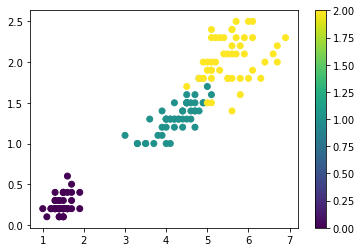

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X[:,2], X[:,3], c = y, cmap = "viridis")
plt.colorbar()
plt.show()

### Glorot and He initialization

In [4]:
keras.layers.Dense(10, activation = "relu", kernel_initializer = "he_normal") ## He initialization
he_avg_init = keras.initializers.VarianceScaling(scale = 2., mode = "fan_avg", distribution = "uniform") ## He initialization with fan_avg and uniform distribution
keras.layers.Dense(10, activation = "sigmoid", kernel_initializer = he_avg_init);

### Implementing Batch Normalization with Keras

In [5]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation = "elu", kernel_initializer = "he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation = "softmax")
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 784)               3136      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 300)               1200      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total para

In [7]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization_v1/gamma:0', True),
 ('batch_normalization_v1/beta:0', True),
 ('batch_normalization_v1/moving_mean:0', False),
 ('batch_normalization_v1/moving_variance:0', False)]

In [8]:
model.layers[1].updates

[<tf.Operation 'batch_normalization_v1/cond_2/Merge' type=Merge>,
 <tf.Operation 'batch_normalization_v1/cond_3/Merge' type=Merge>]

In [9]:
## Batch normalization before activation
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

### Gradient Clipping

In [10]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss = "mse", optimizer = optimizer)

Instructions for updating:
Use tf.cast instead.


### Transfer Learning on Keras

In [11]:
model_clone = keras.models.clone_model(model)
model_clone.set_weights(model.get_weights())
model_2 = keras.models.Sequential(model_clone.layers[:-1])
model_2.add(keras.layers.Dense(1, activation = "sigmoid"))

In [12]:
for layer in model_2.layers[:-1]:
    layer.trainable = False

In [13]:
model_2.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [14]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [15]:
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.0

In [16]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [17]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

In [18]:
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [19]:
np.random.seed(42)

In [20]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation = "selu"))
model_A.add(keras.layers.Dense(8, activation = "softmax"))

In [21]:
model_A.compile(loss = "sparse_categorical_crossentropy", optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ["accuracy"])

In [22]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation = "selu"))
model_B.add(keras.layers.Dense(1, activation = "sigmoid"))

In [23]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [24]:
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
200/200 [==============================] - 2s 9ms/sample - loss: 0.5175 - acc: 0.7300 - val_loss: 0.4300 - val_acc: 0.8205
Epoch 2/20
200/200 [==============================] - 0s 889us/sample - loss: 0.3512 - acc: 0.8900 - val_loss: 0.3181 - val_acc: 0.9006
Epoch 3/20
200/200 [==============================] - 0s 877us/sample - loss: 0.2565 - acc: 0.9550 - val_loss: 0.2545 - val_acc: 0.9391
Epoch 4/20
200/200 [==============================] - 0s 942us/sample - loss: 0.2024 - acc: 0.9750 - val_loss: 0.2143 - val_acc: 0.9493
Epoch 5/20
200/200 [==============================] - 0s 929us/sample - loss: 0.1671 - acc: 0.9850 - val_loss: 0.1882 - val_acc: 0.9564
Epoch 6/20
200/200 [==============================] - 0s 878us/sample - loss: 0.1436 - acc: 0.9850 - val_loss: 0.1672 - val_acc: 0.9594
Epoch 7/20
200/200 [==============================] - 0s 918us/sample - loss: 0.1254 - acc: 

In [25]:
model_clone_A = keras.models.clone_model(model_A)
model_B_on_A = keras.models.Sequential(model_clone_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [26]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1e-3),metrics=["accuracy"])

In [27]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 5ms/sample - loss: 0.6873 - acc: 0.5900 - val_loss: 0.6634 - val_acc: 0.6156
Epoch 2/4
200/200 [==============================] - 0s 410us/sample - loss: 0.6801 - acc: 0.5900 - val_loss: 0.6569 - val_acc: 0.6237
Epoch 3/4
200/200 [==============================] - 0s 405us/sample - loss: 0.6732 - acc: 0.6000 - val_loss: 0.6507 - val_acc: 0.6349
Epoch 4/4
200/200 [==============================] - 0s 412us/sample - loss: 0.6667 - acc: 0.6150 - val_loss: 0.6447 - val_acc: 0.6400
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 7ms/sample - loss: 0.5812 - acc: 0.6700 - val_loss: 0.4623 - val_acc: 0.8083
Epoch 2/16
200/200 [==============================] - 0s 899us/sample - loss: 0.4293 - acc: 0.8350 - val_loss: 0.3702 - val_acc: 0.8621
Epoch 3/16
200/200 [==============================] - 0s 917us/sample - loss: 0.3410 - acc: 0.8800 -

In [28]:
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 61us/sample - loss: 0.0813 - acc: 0.9795


[0.08126986318826676, 0.9795]

In [29]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 62us/sample - loss: 0.1125 - acc: 0.9775


[0.11253115373849869, 0.9775]

In [30]:
(100 - 97.75) / (100 - 97.45)

0.8823529411764716